# Optimizing the Data Processing

[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_en/dataset/optimize.ipynb)

Data is the most important part of the whole deep learning, because the quality of the data determines the upper limit of the final result, and the quality of the model is only to infinitely approach this upper limit, so high-quality data input will play a positive role in the entire deep neural network. The data in the entire process of data processing and data augmentation is like water through the pipeline, continuous flows to the training system, as shown in the figure:

![pipeline](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/pipeline.png)

MindSpore Dataset provides data processing and data augmentation functions for users. In the pipeline process, if each step can be properly used, the data performance will be greatly improved.

This section describes how to optimize performance during data loading, data processing, and data augmentation based on the CIFAR-10 dataset.

In addition, the storage, architecture and computing resources of the operating system will influence the performance of data processing to a certain extent.

## Downloading the Dataset

Run the following command to obtain the dataset.

Download the CIFAR-10 binary format dataset and extract the dataset file to the `./datasets/` directory, which is used when the data is loaded.

In [1]:
from download import download
import os
import shutil

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"
path = download(url, "./datasets", kind="tar.gz", replace=True)  # Download CIFAR-10 dataset

test_path = "./datasets/cifar-10-batches-bin/test"
train_path = "./datasets/cifar-10-batches-bin/train"
os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
if not os.path.exists(os.path.join(test_path, "test_batch.bin")):
    shutil.move("./datasets/cifar-10-batches-bin/test_batch.bin", test_path)
[shutil.move("./datasets/cifar-10-batches-bin/"+i, train_path) for i in os.listdir("./datasets/cifar-10-batches-bin/") if os.path.isfile("./datasets/cifar-10-batches-bin/"+i) and not i.endswith(".html") and not os.path.exists(os.path.join(train_path, i))]

The directory structure of the decompressed dataset file is as follows:

```text
./datasets/cifar-10-batches-bin
├── readme.html
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin
```

## Optimizing the Data Loading Performance

MindSpore supports loading common datasets in fields such as computer vision, natural language processing, datasets in specific formats, and user-defined datasets. The underlying implementation of different dataset loading interfaces is different, and the performance is also different, as follows:

|                           | Common Dataset | Standard Format (MindRecord) | User-defined Dataset |
| :----:                    | :----:         | :----:                       | :----:               |
| Underlying implementation | C++            | C++                          | Python               |
| Performance               | High           | High                         | Medium               |

You can refer to the following figure to select the dataset loading interface suitable for your scenario:

![data-loading-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/data_loading_performance_scheme.png)

Suggestions on data loading performance optimization are as follows:

- For commonly used datasets that have already provided loading interfaces, it is preferred to use the dataset loading interface provided by MindSpore to load, which can obtain better loading performance. For details, see [Built-in Dataset Loading Interfaces](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html). If the performance cannot meet the requirements, use the multi-thread concurrency solution, i.e., adjust the parameter `num_parallel_workers`(default: 8) of the dataset interface to achieve a better performance.
- For a dataset format that is not supported, it is recommended to convert the dataset to the MindRecord data format before loading it using the `MindDataset` class (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.MindDataset.html) for detailed use). For detailed contents, please refer to [Converting Dataset to MindRecord](https://www.mindspore.cn/tutorials/en/master/dataset/record.html). If the performance cannot meet the requirements, use the multi-thread concurrency solution, i.e., adjust the parameter `num_parallel_workers`(default: 8) of the dataset interface to achieve a better performance.
- For dataset formats that are not supported, the user-defined `GeneratorDataset` class is preferred for implementing fast algorithm verification (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.GeneratorDataset.html) for detailed use). If the performance cannot meet the requirements, the multi-process / multi-thread concurrency solution can be used. For example:

    1. Increase the parameter `num_parallel_workers`(default: 8) of the dataset interface to improve concurrency;
    2. Set the parameter `python_multiprocessing`(default: True) of the dataset interface to True / False to enable multi-process / multi-thread concurrency mode. The multi-process mode achieves better performance in CPU-bound tasks, and multi-thread mode is better in IO bound tasks;

        **Note**: If you set `python_multiprocessing=True`(default: True) and `num_parallel_workers>1`(default: 1), which indicates that the multi-process mode is started for data load acceleration. At this time, as the dataset iterates, the memory consumption of the subprocess will gradually increase, mainly because the subprocess of the user-defined dataset obtains the member variables from the main process in the Copy On Write way. Example: If you define a dataset with `__init__` function which contains a large number of member variable data (for example, a very large file name list is loaded during the dataset construction) and uses the multi-process mode, which may cause the problem of OOM (the estimated total memory usage is: `(num_parallel_workers+1) * size of the parent process` ). The simplest solution is to replace python objects (such as list/dict/int/float/string) with non referenced data types (such as Pandas, Numpy or PyArrow objects) for member variables, or load less meta data in member variables, or configure `python_multiprocessing=False` using multi-threading mode.
    3. If there is `Using shared memory queue, but rowsize is larger than allocated memory ...` log prompt, then increase the parameter `max_rowsize` of dataset interface or set it to `None` to improve the efficiency of data transfer between processes.

Based on the preceding suggestions of data loading performance optimization, this experience uses the built-in dataset load operation `Cifar10Dataset` class (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html) for detailed use), the `MindDataset` class after data conversion, and uses the `GeneratorDataset` class to load data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in dataset operation to load the CIFAR-10 dataset in binary format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [5]:
import mindspore.dataset as ds
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[181, 185, 194],
  [184, 187, 196],
  [189, 192, 201],
  ...
  [178, 181, 191],
  [171, 174, 183],
  [166, 170, 179]],
 [[182, 185, 194],
  [184, 187, 196],
  [189, 192, 201],
  ...
  [180, 183, 192],
  [173, 176, 185],
  [167, 170, 179]],
 [[185, 188, 197],
  [187, 190, 199],
  [193, 196, 205],
  ...
  [182, 185, 194],
  [176, 179, 188],
  [170, 173, 182]],
 ...
 [[176, 174, 185],
  [172, 171, 181],
  [174, 172, 183],
  ...
  [168, 171, 180],
  [164, 167, 176],
  [160, 163, 172]],
 [[172, 170, 181],
  [171, 169, 180],
  [173, 171, 182],
  ...
  [164, 167, 176],
  [160, 163, 172],
  [156, 159, 168]],
 [[171, 169, 180],
  [173, 171, 182],
  [177, 175, 186],
  ...
  [162, 165, 174],
  [158, 161, 170],
  [152, 155, 164]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 6)}


2. Use the `Cifar10ToMR` class to convert the CIFAR-10 dataset into the MindSpore data format. In this example, the CIFAR-10 dataset in Python file format is used. Then use the `MindDataset` class to load the dataset in the MindSpore data format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for data and a data record is read through the iterator.

In [6]:
from mindspore.mindrecord import Cifar10ToMR

trans_path = "./transform/"

if not os.path.exists(trans_path):
    os.mkdir(trans_path)

os.system("rm -f {}cifar10*".format(trans_path))

# download CIFAR-10 python
py_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-python.tar.gz"
download(py_url, "./datasets", kind="tar.gz", replace=True)

cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path, cifar10_mindrecord_path)
# execute transformation from CIFAR-10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_files=cifar10_mindrecord_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator(output_numpy=True)))

{'data': Tensor(shape=[1289], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
   0,   2,   1,   1,   1,   1,   1,   2,   1,   1,   1,   2,   2,   2,   2,   2,   4,   3,   2,   2,   2,   2,   5,   4, 
   4,   3,   4,   6,   5,   6,   6,   6,   5,   6,   6,   6,   7,   9,   8,   6,   7,   9,   7,   6,   6,   8,  11,   8, 
   9,  10,  10,  10,  10,  10,   6,   8,  11,  12,  11,  10,  12,   9,  10,  10,  10, 255, 219,   0,  67,   1,   2,   2, 
   ...
   ...
   ...
  39, 227, 206, 143, 241,  91, 196, 154, 230, 189, 125, 165, 105, 218,  94, 163, 124, 146,  11, 187,  29,  34, 217, 210, 
  23, 186,  56,  14, 192,  19, 181,   1,  57,  36,  14,  51, 211, 173, 105,   9, 191, 100, 212, 174, 122,  25, 110,  39, 
  11, 133, 193, 226, 169,  73,  36, 234,  69,  90, 222,  93,  31, 223, 115, 255, 217]), 'id': Tensor(shape=[], dtype=Int64, value= 46084), 'label': Tensor(shape=[], dtype=Int64, value= 5)}


3. The `GeneratorDataset` class is used to load the user-defined dataset, and the multi-process optimization solution is used. Four processes are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data, and a data record is read through the iterator.

In [7]:
import numpy as np
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create a GeneratorDataset object for reading data
dataset = ds.GeneratorDataset(source=generator_func(5), column_names=["data"], num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## Optimizing the Shuffle Performance

The shuffle operation is used to shuffle ordered datasets or repeated datasets. MindSpore provides the `shuffle` function for users which is based by memory cache. A larger value of `buffer_size` indicates a higher shuffling degree, consuming more computing resources and more time. This API allows users to shuffle the data at any time during the entire pipeline process. For the detailed contents, refer to [shuffle processing](https://www.mindspore.cn/docs/en/master/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.shuffle.html#mindspore-dataset-dataset-shuffle).
Because it's based by memory cache, the performance of this method is not as good as that of setting the parameter `shuffle=True`(default: True) of dataset interface to shuffle data directly. For details, see [Built-in Dataset Loading Interfaces](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html).

Shuffle optimization suggestion:

![shuffle-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/shuffle_performance_scheme.png)

Suggestions on shuffle performance optimization are as follows:

- Use the `shuffle=True` parameter of built-in dataset loading operations to shuffle data.
- If the `shuffle` function is used and the mixed effect still cannot meet the requirements, increase the parameter `buffer_size` to improve the mixed effect. If the `shuffle` function is used and the host memory usage is too high, decrease the parameter `buffer_size`.

Based on the preceding shuffle optimization suggestions, the parameter `shuffle` of the `Cifar10Dataset` class of built-in loading operations and the `Shuffle` function are used to shuffle data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in dataset operation to load the CIFAR-10 dataset. In this example, the CIFAR-10 dataset in binary format is used, and the `shuffle` parameter is set to True to perform data shuffle. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [8]:
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[213, 205, 194],
  [215, 207, 196],
  [219, 210, 200],
  ...
  [253, 254, 249],
  [253, 254, 249],
  [253, 254, 249]],
 [[218, 208, 198],
  [220, 210, 200],
  [222, 212, 202],
  ...
  [253, 254, 249],
  [253, 254, 249],
  [253, 254, 249]],
 [[219, 209, 198],
  [222, 211, 200],
  [224, 214, 202],
  ...
  [254, 253, 248],
  [254, 253, 248],
  [254, 253, 248]],
 ...
 [[135, 141, 139],
  [135, 141, 139],
  [146, 152, 150],
  ...
  [172, 174, 172],
  [181, 182, 182],
  [168, 168, 167]],
 [[113, 119, 117],
  [109, 115, 113],
  [117, 123, 121],
  ...
  [155, 159, 156],
  [150, 155, 155],
  [135, 140, 140]],
 [[121, 127, 125],
  [117, 123, 121],
  [121, 127, 125],
  ...
  [180, 184, 180],
  [141, 146, 144],
  [125, 130, 129]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 8)}


2. Use the `shuffle` function to shuffle data. Set `buffer_size` to 3 and use the `GeneratorDataset` class to generate data.

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[3 4 5 6 7]
[1 2 3 4 5]
[0 1 2 3 4]
[4 5 6 7 8]


## Optimizing the Data Augmentation Performance

During the training, especially when the dataset is small, users can use data augmentation to preprocess images to enrich the dataset. MindSpore provides multiple data augmentation methods, including:

- Vision data augmentation operations, mainly implemented in C++. Please refer: [vision augmentations](https://mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.vision)
- Nlp data augmentation operations, mainly implemented in C++. Please refer: [nlp augmentations](https://mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.text).
- Audio data augmentation operations, mainly implemented in C++. Please refer: [audio augmentations](https://mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.audio).
- Also users can define Python functions as needed to perform data augmentation.

The performance varies according to the underlying implementation (C++ or Python) methods. This is shown below:

| Programming Language | Description                                          |
| :----:               | :----:                                               |
| C++                  | Implemented in C++ code which has higher performance |
| Python               | Implemented in Python code which is more flexible    |

Data augmentation operation reference:

![data-enhancement-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/data_enhancement_performance_scheme.png)

Suggestions on data augmentation performance optimization are as follows:

- Suggest to use mindspore data augmentation operator to get higher performance. If the performance cannot meet the requirements, refer to follow steps to improve:
    1. use multi-thread
        Increase the parameter `num_parallel_workers`(default: 8) of `map` to improve the performance.
    2. use fusion operator
        If the cpu usage is too high (For example: single-machine multi-card training), better performance can be achieved by using the fusion operation (aggregating the functions of two or more operations into one operation) to reduce the CPU consumption. You can make it effective by configuring the environment variable `export OPTIMIZE=true`. Examples of fusion are as follows:

        ![operation-fusion](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/operation_fusion.png)
    3. use compose operator
        If the cpu usage is too high (For example: single-machine multi-card training), receive multiple augmentation operations through one map operation (these operations will be applied in order) to reduce CPU contention and achieve better performance. Examples are as follows:

        ![compose](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_en/dataset/images/compose.png)

- If the user-defined Python functions are used to perform data augmentation and the performance still cannot meet the requirements, refer to follow steps to improve. Or if the performance still cannot be improved, in this case, optimize the user-defined Python code.
    1. Increase the parameter `num_parallel_workers`(default: 8) of the `map` interface to improve concurrency;
    2. Set the parameter `python_multiprocessing`(default: True) of the `map` interface to True / False to enable multi-process / multi-thread concurrency mode. The multi-process mode achieves better performance in CPU-bound tasks, and multi-thread mode is better in IO bound tasks;
    3. If there is `Using shared memory queue, but rowsize is larger than allocated memory ...` log prompt, then increase the parameter `max_rowsize` of `map` interface or set it to `None` to improve the efficiency of data transfer between processes.

Based on the preceding suggestions of data augmentation performance optimization, the C++ implemented operations and user-defined Python functions are used to perform data augmentation. The code is displayed as follows:

1. The C++ implemented operations are used to perform data augmentation. During data augmentation, the multi-thread optimization solution is used. Four threads are enabled to concurrently complete the task. The operation fusion optimization solution is used and the `RandomResizedCrop` fusion class is used to replace the `RandomResize` and `RandomCrop` classes.

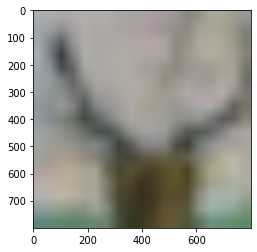

In [10]:
import mindspore.dataset.vision as vision
import matplotlib.pyplot as plt

cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
transforms = vision.RandomResizedCrop((800, 800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms, input_columns="image", num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. A user-defined Python function is used to perform data augmentation. During data augmentation, the multi-process optimization solution is used, and four processes are enabled to concurrently complete the task.

In [11]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

def preprocess(x):
    return (x**2,)
ds4 = ds3.map(operations=preprocess, input_columns="data", python_multiprocessing=True, num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## Batch Operation Performance Optimization

In the final stage of data processing, the batch operation will be used to organize multiple pieces of data into a batch, and then transferred to the network for training. The performance optimization suggestions for batch operation are as follows:

- If `batch` operation is only configured `batch_size` and `drop_remainder`, and `batch_size` is large. It is recommended to increase `num_parallel_workers`(default: 8) to improve the performance;
- If `per_batch_map` is also configured, the recommended configuration is as follows:
    1. Increase the parameter `num_parallel_workers`(default: 8) of the `batch` interface to improve concurrency;
    2. Set the parameter `python_multiprocessing`(default: True) of the `batch` interface to True / False to enable multi-process / multi-thread concurrency mode. The multi-process mode achieves better performance in CPU-bound tasks, and multi-thread mode is better in IO bound tasks;
    3. If there is `Using shared memory queue, but rowsize is larger than allocated memory ...` log prompt, then increase the parameter `max_rowsize` of `batch` interface or set it to `None` to improve the efficiency of data transfer between processes.

## Optimizing the Operating System Performance

Data processing is performed on the Host. Therefore, configurations of the running environment may affect the processing performance.  Major factors include storage, NUMA architecture, and CPU (computing resources).

1. Storage

    The data loading process involves frequent disk operations, and the performance of disk reading and writing directly affects the speed of data loading. Solid State Drive (SSD) is recommended for storing large datasets when the dataset is large. SSDs generally have higher read and write speeds than ordinary disks, reducing the impact of I/O operations on data processing performance.

    In general, the loaded data will be cached into the operating system's page cache, which reduces the overhead of subsequent reads to a certain extent and accelerates the data loading speed of subsequent Epochs. Users can also manually cache the augmented data through the [single-node caching](https://www.mindspore.cn/tutorials/en/master/dataset/cache.html) technology provided by MindSpore, avoiding duplicate data loading and data augmentation.

2. NUMA architecture

    NUMA, Non-Uniform Memory Access, is a memory architecture that was born to solve the scalability problem in the traditional symmetric multiprocessor (SMP) architecture. In traditional architectures, multiple processors share a memory bus, which is prone to problems such as insufficient bandwidth and memory conflicts.

    In the NUMA architecture, processors and memory are divided into groups, each called a node, each node has a separate integrated memory controller (IMC) bus for intra-node communication, and different nodes communicate with each other through a fast path interconnect (QPI). For a node, memory within the same node is called local memory, while memory in other nodes is called external memory. The delay in accessing local memory will be less than the delay in accessing external memory.

    During data processing, you can reduce the latency of memory access by binding the process to the node. In general, we can use the following command to bind the process to the node node, or you can configure the environment variable `export DATASET_ENABLE_NUMA=True` to make each training process bound to different numa nodes.

    ```bash
    numactl --cpubind=0 --membind=0 python train.py
    ```

3. CPU (computing resource)

    Although the data processing speed can be accelerated through multi-threaded parallel technology, there is actually no guarantee that CPU computing resources will be fully utilized. If you can artificially complete the configuration of computing resources in advance, it will be able to improve the utilization of CPU computing resources to a certain extent.

    - Resource allocation

        In distributed training, multiple training processes are run on one device. These training processes allocate and compete for computing resources based on the policy of the operating system. When there is a large number of processes, data processing performance may deteriorate due to resource contention. In some cases, users need to manually allocate resources to avoid resource contention.

        ```bash
        numactl --cpubind=0 python train.py
        ```

    - CPU frequency

        For energy efficiency reasons, the operating system adjusts the CPU operating frequency as needed, but lower power consumption means that computing performance is degraded and data processing is slowed down. In order to get the most out of the CPU's maximum computing power, you need to manually set the CPU's operating frequency. If it is found that the CPU operation mode of the operating system is balanced mode or energy-saving mode, you can improve the performance of data processing by adjusting it to performance mode.

        ```bash
        cpupower frequency-set -g performance
        ```

    - Multi-thread competition

        If the user uses the `cv2`, `numpy` and `numba` third-party libraries in data processing stage, and uses the `top` command to view the CPU. If `sy` occupation is high, while the `us` occupation is low, which indicates that there is thread competition, which can be solved as follows:
        1. If there is a `cv2` operation of opencv in the data processing, use `cv2.setNumThreads(2)` to set the number of `cv2` global threads.
        2. If there is a `numpy` operation in the data processing, use `export OPENBLAS_NUM_THREADS=1` to set the number of `OPENBLAS` threads.
        3. If there is a `numba` operation in the data processing, use `numba.set_num_threads(1)` to set the number of threads for `numba`.

    - High CPU/Memory usage

        Because MindSpore Dataset mainly uses the CPU and memory on the host side for data processing, in some environments with relatively few resources (CPU and memory), the CPU consumption is too high or the memory consumption is too high during data preprocessing. You can reduce the CPU and memory usage by the following methods, but at the same time, you will lose some performance. For more detailed instructions, please refer to: https://blog.csdn.net/guozhijian521/article/details/123552540
        1. Before defining the dataset `**Dataset` object, set the prefetch size of `Dataset`  data processing, `ds.config.set_prefetch_size(2)`.
        2. When defining the `**Dataset` object, set its parameter `num_parallel_workers` as 1.
        3. If you further use `.map(...)` operation on `**Dataset` object, you can set `.map(...)` operation's parameter `num_parallel_workers` as 1.
        4. If you further use `.batch(...)` operation on `**Dataset` object, you can set `.batch(...)` operation's parameter `num_parallel_workers` as 1.
        5. If you further use `.shuffle(...)` operation on `**Dataset` object, you can reduce the parameter `buffer_size`.
        6. If you have multi `map` operations, you can compose the augmentation operations by only one `map`.

## Optimization for Parallelism of Standalone Training VS Distributed Training

When using MindSpore for standalone or distributed training, the setting of the parameter `num_parallel_workers` should follow the following principles:

- The summary of the parameter `num_parallel_workers` set for each data loading and processing operation should not be greater than the maximum number of CPU cores of the machine, otherwise it will cause resource competition between each operation.
- Before setting the num_parallel_workers parameter, it is recommended to use MindSpore's Profiler (performance analysis) tool to analyze the performance of each operation in the training, and allocate more resources to the operation with pool performance, that is, set a large num_parallel_workers to balance the throughput between various operations and avoid unnecessary waiting.
- In a standalone training scenario, increasing the num_parallel_workers parameter can often directly improve processing performance, but in a distributed scenario, due to increased CPU competition, blindly increasing num_parallel_workers may lead to performance degradation. You need to try to use a compromise value.

## Dataset AutoTune for Dataset Pipeline

MindSpore provides a tool named Dataset AutoTune for optimizing dataset.The Dataset AutoTune can automatically tune Dataset pipelines to improve performance. The detailed usage please refer to [Dataset AutoTune for Dataset Pipeline](https://www.mindspore.cn/tutorials/en/master/dataset/dataset_autotune.html).

## Enabling Heterogeneous Acceleration for Data

MindSpore provides a computing load balancing technology which can distribute the MindSpore Tensor computing to different heterogeneous hardware. On one hand, it balances the computing overhead between different hardware, on the other hand, it uses the advantages of heterogeneous hardware to accelerate the computing. For the detailed usage, please refer to [Enabling Heterogeneous Acceleration for Data](https://www.mindspore.cn/tutorials/en/master/dataset/dataset_offload.html).